# Project Inquiries:

1) Is the Earth’s temperature rising over time?

2) Does Earth’s temperature fluctuate in a predictable pattern?

3) Can we use readings of past Earth temperatures to predict future Earth temperatures?

4) Does taking the average temperature over land very in pattern, predictability, or variability from temperature taken over land and ocean?

In [1]:
# imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

import wrangle

# import fbprophet

import warnings
warnings.filterwarnings("ignore")

# Acquire

In [2]:
df = pd.read_csv('GlobalTemperatures.csv')
df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


# Prepare

In [3]:
df_land, df_ocean = wrangle.pre_split_prep()

### Split into train using ~80% train, ~13% validate, and ~7% test, seperating data at the end of the nearest year

In [4]:
train_land, validate_land, test_land, train_ocean, validate_ocean, test_ocean = wrangle.tvt_split(df_land, df_ocean)

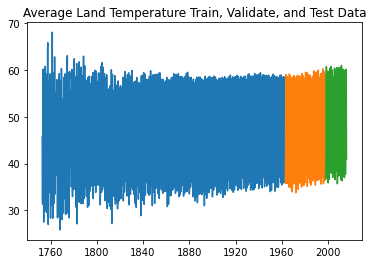

In [7]:

plt.title("Average Land Temperature Train, Validate, and Test Data")
plt.plot(train_land.index, train_land.LandAverageTemperature)
plt.plot(validate_land.index, validate_land.LandAverageTemperature)
plt.plot(test_land.index, test_land.LandAverageTemperature)
plt.show()

In [8]:


plt.title("Average Land and Ocean Temperature Train, Validate, and Test Data")
plt.plot(train_ocean.index, train_ocean.LandAndOceanAverageTemperature)
plt.plot(validate_ocean.index, validate_ocean.LandAndOceanAverageTemperature)
plt.plot(test_ocean.index, test_ocean.LandAndOceanAverageTemperature)

NameError: name 'df_lo' is not defined

# Explore

View each temperature line next to the other, resample using the average temperature by year, and by decade.

In [ ]:
train_land.describe()

In [ ]:
train_ocean.describe()

In [ ]:
plt.title("Average Temperature by Month")
plt.plot(train_land)
plt.plot(train_ocean)
plt.show

In [ ]:
plt.title("Average Temperature by Year")
plt.plot(train_land.resample('y').mean())
plt.plot(train_ocean.resample('y').mean())
plt.show

In [ ]:
plt.title("Average Temperature by Decade")
plt.plot(train_land.resample('10y').mean())
plt.plot(train_ocean.resample('10y').mean())
plt.show

In [ ]:
col = 'LandAverageTemperature'

print(col,'\n')
_ = sm.tsa.seasonal_decompose(train_land[col].resample('M').mean()).plot()
plt.show()

In [ ]:
col = 'LandAndOceanAverageTemperature'

print(col,'\n')
_ = sm.tsa.seasonal_decompose(train_ocean[col].resample('M').mean()).plot()
plt.show()

Observation 1: Changes in temperature are irregular.

Observation 2: land and ocean temperature has a slight upward trend overall, and very little variance.

Observation 3: Land only temperature shows significant variance untill after 1840 where there begins a slight upward trend. It is possibel the technological advancements lessoning measurement error can account for this trend.

# Modeling

In [ ]:
# evaluation function to compute rmse

def evaluate_land(target_var):
    rmse = round(sqrt(mean_squared_error(validate_land[target_var], yhat_land_df[target_var])), 4)
    return rmse


In [ ]:
# evaluation function to compute rmse

def evaluate_ocean(target_var):
    rmse = round(sqrt(mean_squared_error(validate_ocean[target_var], yhat_ocean_df[target_var])), 4)
    return rmse

In [ ]:
# plot and evaluate 
def plot_and_eval_land(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train_land[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate_land[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_land_df[target_var])
    plt.title(target_var)
    rmse = evaluate_land(target_var)
    print(target_var, f'-- RMSE: {rmse}')
    plt.show()

In [ ]:
# plot and evaluate 
def plot_and_eval_ocean(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train_ocean[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate_ocean[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_ocean_df[target_var])
    plt.title(target_var)
    rmse = evaluate_ocean(target_var)
    print(target_var, f'-- RMSE: {rmse}')
    plt.show()


In [ ]:
# Create the empty dataframe
eval_df_land = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df_land(model_type, target_var):
    rmse = evaluate_land(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df_land.append(d, ignore_index = True)

In [ ]:
# Create the empty dataframe
eval_df_ocean = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df_ocean(model_type, target_var):
    rmse = evaluate_ocean(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df_ocean.append(d, ignore_index = True)

### Make predictions using last observed value

In [ ]:
temps = train_land['LandAverageTemperature'][-1:][0]

yhat_land_df = pd.DataFrame({'LandAverageTemperature': [temps]}, index = validate_land.index)

yhat_land_df.head(2)

In [ ]:
plot_and_eval_land('LandAverageTemperature')

In [ ]:
eval_df_land = append_eval_df_land('Last Observed Value', 'LandAverageTemperature')
eval_df_land

In [ ]:
temps = train_ocean['LandAndOceanAverageTemperature'][-1:][0]

yhat_ocean_df = pd.DataFrame({'LandAndOceanAverageTemperature': [temps]}, index = validate_ocean.index)

yhat_ocean_df.head(2)

In [ ]:
plot_and_eval_ocean('LandAndOceanAverageTemperature')

In [ ]:
eval_df_ocean = append_eval_df_ocean("Last Observed Value", 'LandAndOceanAverageTemperature')
eval_df_ocean

### Make predictions using simple average

In [ ]:
temps = round(train_land['LandAverageTemperature'].mean(),2)

yhat_land_df = pd.DataFrame({'LandAverageTemperature': [temps]}, index = validate_land.index)

yhat_land_df.head(2)

In [ ]:
plot_and_eval_land('LandAverageTemperature')

In [ ]:
eval_df_land = append_eval_df_land('Simple Average', 'LandAverageTemperature')
eval_df_land

In [ ]:
temps = round(train_ocean['LandAndOceanAverageTemperature'].mean(),2)

yhat_ocean_df = pd.DataFrame({'LandAndOceanAverageTemperature': [temps]}, index = validate_ocean.index)

yhat_ocean_df.head(2)

In [ ]:
plot_and_eval_ocean('LandAndOceanAverageTemperature')

In [ ]:
eval_df_ocean = append_eval_df_ocean('Simple Average', 'LandAndOceanAverageTemperature')
eval_df_ocean

### Make predictions based on moving average for month, year, and decade.

In [ ]:
for period in [1,12,120]:

    temps = round(train_land['LandAverageTemperature'].rolling(period).mean().iloc[-1],2)

    yhat_land_df = pd.DataFrame({'LandAverageTemperature': [temps]}, index = validate_land.index)
    
    print(plot_and_eval_land('LandAverageTemperature'))
    
    eval_df_land = append_eval_df_land(f'{period}Month Moving Average', 'LandAverageTemperature')

In [ ]:
eval_df_land

In [ ]:
for period in [1,12,120]:

    temps = round(train_ocean['LandAndOceanAverageTemperature'].rolling(period).mean().iloc[-1],2)

    yhat_ocean_df = pd.DataFrame({'LandAndOceanAverageTemperature': [temps]}, index = validate_ocean.index)
    
    print(plot_and_eval_ocean('LandAndOceanAverageTemperature'))
    
    eval_df_ocean = append_eval_df_ocean(f'{period}Month Moving Average', 'LandAndOceanAverageTemperature')

In [ ]:
eval_df_ocean

### Make predictions using Holt's Linear Trend

In [ ]:
model = Holt(train_land['LandAverageTemperature'], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_items = model.predict(start = validate_land.index[0], 
                           end = validate_land.index[-1])
yhat_land_df['LandAverageTemperature'] = round(yhat_items, 2)

In [ ]:
plot_and_eval_land('LandAverageTemperature')

In [ ]:
model = Holt(train_ocean['LandAndOceanAverageTemperature'], exponential = False)
model = model.fit(smoothing_level = .1, 
                  smoothing_slope = .1, 
                  optimized = False)
yhat_items = model.predict(start = validate_ocean.index[0], 
                           end = validate_ocean.index[-1])
yhat_ocean_df['LandAndOceanAverageTemperature'] = round(yhat_items, 2)

In [ ]:
plot_and_eval_ocean('LandAndOceanAverageTemperature')

### Make Predictions using previous cycle

In [ ]:
train_land = df_land[:'1996'].copy()
train_cycle_land = df_land['1996'].copy()
validate_land = df_land['1997'].copy()

In [ ]:
yhat_land_df = train_cycle_land + train_land.diff(365).mean()

In [ ]:
yhat_land_df.index = validate_land.index

In [ ]:
plot_and_eval_land('LandAverageTemperature')
eval_df_land = append_eval_df_land('Previous Cycle', 'LandAverageTemperature')

In [ ]:
train_ocean = df_lo[:'2003']
train_ocean_cycle = df_lo['2003']
validate_ocean = df_lo['2004']

yhat_ocean_df = train_ocean_cycle + train_ocean.diff(365).mean()

yhat_ocean_df.index = validate_ocean.index

plot_and_eval_ocean('LandAndOceanAverageTemperature')

### Make predictions using the Holt-Winter method

In [ ]:
train_land = df_land[:'1962-12-01'] 
validate_land = df_land['1963-01-01':'1997-12-01']
test_land = df_land['1998-01-01':]

train_ocean = df_lo[:'1982-12-01']
validate_ocean = df_lo['1983-01-01':'2004-12-01']
test_ocean = df_lo['2005-01-01':]

In [ ]:
model = ExponentialSmoothing(np.asarray(train_land['LandAverageTemperature']) ,seasonal_periods=12 ,trend='add', seasonal='add',)

model = model.fit()

yhat_items = model.forecast(len(yhat_land_df))

yhat_land_df['LandAverageTemperature'] = yhat_items

In [ ]:
plot_and_eval_land('LandAverageTemperature')

In [ ]:
model = ExponentialSmoothing(np.asarray(train_ocean['LandAndOceanAverageTemperature']) ,seasonal_periods=12 ,trend='add', seasonal='add',)

model = model.fit()

yhat_items = model.forecast(len(yhat_ocean_df))

yhat_ocean_df['LandAndOceanAverageTemperature'] = yhat_items

In [ ]:
plot_and_eval_ocean('LandAndOceanAverageTemperature')